In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
from dataclasses import dataclass
from typing import List, Tuple, Dict
sys.path.append('../')
from pipeline_simulator.batches import Batch, ForwardBatch, BackwardBatch, BackwardInputBatch, BackwardWeightBatch, BubbleBatch
from pipeline_simulator.batches import update_times
from pipeline_simulator.policy import PipelinePolicy, GpipePolicy, PipeDreamPolicy, LearnedPolicy, OurPolicy, FixedPolicy, ZeroBubblePolicy
from pipeline_simulator.schedule import PipelineSimulator, calc_delta_x

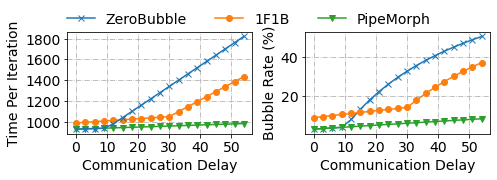

In [2]:
num_stages, num_batches = 4, 30
update_times([10]*num_stages, [10]*num_stages, [10]*num_stages, [1]*num_stages)
ls = ['-x', '-o', '-v', '-d', '-D']
lsid = 0
policy = OurPolicy(num_stages)
simulator = PipelineSimulator(num_stages, num_batches, policy, [], {}, True)
simulator.simulate()
health_time = simulator.get_iter_time()
slow_link = (2, 3)
fig, axs = plt.subplots(1, 2, figsize=(7, 2.5))

# ZB
policy = OurPolicy(num_stages)
simulator = PipelineSimulator(num_stages, num_batches, policy, [], {}, True)
simulator.simulate()
simulator.export("./originalzb.txt")
iter_times, bubbles = [], []
for delay_time in range(0, 55, 3):
    comm_delay = {slow_link: delay_time}
    policy = FixedPolicy(num_stages, "./originalzb.txt")
    simulator = PipelineSimulator(num_stages, num_batches, policy, [], comm_delay, True)
    simulator.simulate()
    iter_time = simulator.get_iter_time()
    iter_times.append(iter_time)
    bubbles.append(simulator.get_bubble_rate())
axs[0].plot(list(range(0, 55, 3)), np.array(iter_times), ls[lsid] ,label=f"ZeroBubble", zorder=100)
axs[1].plot(list(range(0, 55, 3)), np.array(bubbles), ls[lsid])
lsid += 1

# 1F1B
policy = PipeDreamPolicy(num_stages)
simulator = PipelineSimulator(num_stages, num_batches, policy, [], {}, False)
simulator.simulate()
simulator.export("./1f1b.txt")
iter_times, bubbles = [], []
for delay_time in range(0, 55, 3):
    comm_delay = {slow_link: delay_time}
    policy = FixedPolicy(num_stages, "./1f1b.txt")
    simulator = PipelineSimulator(num_stages, num_batches, policy, [], comm_delay, False)
    simulator.simulate()
    iter_time = simulator.get_iter_time()
    iter_times.append(iter_time)
    bubbles.append(simulator.get_bubble_rate())
axs[0].plot(list(range(0, 55, 3)), np.array(iter_times), ls[lsid] ,label=f"1F1B")
axs[1].plot(list(range(0, 55, 3)), np.array(bubbles), ls[lsid])
lsid += 1

# Ours
iter_times, bubbles = [], []
for delay_time in range(0, 55, 3):
    comm_delay = {slow_link: delay_time}
    policy = OurPolicy(num_stages)
    simulator = PipelineSimulator(num_stages, num_batches, policy, [], comm_delay, True)
    simulator.simulate()
    iter_time = simulator.get_iter_time()
    iter_times.append(iter_time)
    bubbles.append(simulator.get_bubble_rate())
axs[0].plot(list(range(0, 55, 3)), np.array(iter_times), ls[lsid] ,label=f"PipeMorph")
axs[1].plot(list(range(0, 55, 3)), np.array(bubbles), ls[lsid])
lsid += 1

for i in range(2):
    axs[i].set_xlabel("Communication Delay", fontdict={"fontsize": 14})
    axs[i].set_ylabel("Time Per Iteration" if i == 0 else "Bubble Rate (%)", fontdict={"fontsize": 14})
    axs[i].grid(linestyle='-.')
    plt.sca(axs[i])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
legend = plt.figlegend(loc='upper center', bbox_to_anchor=(0.5, 1.02), fontsize=14, ncols=3, frameon=False)
plt.tight_layout(pad=1.05, rect=(0, 0, 1, 0.9)) 
plt.savefig("compbubble.pdf")

<Figure size 648x180 with 0 Axes>

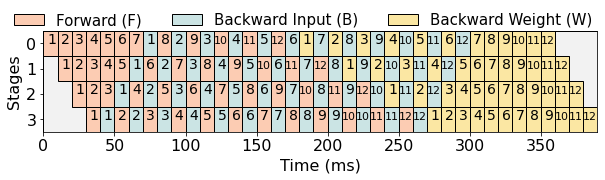

In [3]:
num_stages, num_batches = 4, 12
update_times([10]*num_stages, [10]*num_stages, [10]*num_stages, [1]*num_stages)
policy = OurPolicy(num_stages)
plt.figure(figsize=(9, 2.5))
simulator = PipelineSimulator(num_stages, num_batches, policy, [], {}, True)
simulator.simulate()
simulator.plot()
plt.title("")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.bar(0, 0, label="Forward (F)", color=ForwardBatch(0).color, edgecolor='black')
plt.bar(0, 0, label="Backward Input (B)", color=BackwardInputBatch(0).color, edgecolor='black')
plt.bar(0, 0, label="Backward Weight (W)", color=BackwardWeightBatch(0).color, edgecolor='black')
plt.xlabel("Time (ms)", fontdict={"fontsize": 16})
plt.ylabel("Stages", fontdict={"fontsize": 16})
legend = plt.figlegend(loc='upper center', bbox_to_anchor=(0.5, 1.02), fontsize=15, ncols=3, frameon=False)
plt.tight_layout(pad=1.0, rect=(0, 0, 1, 0.9)) 
plt.savefig("idealzb.pdf")

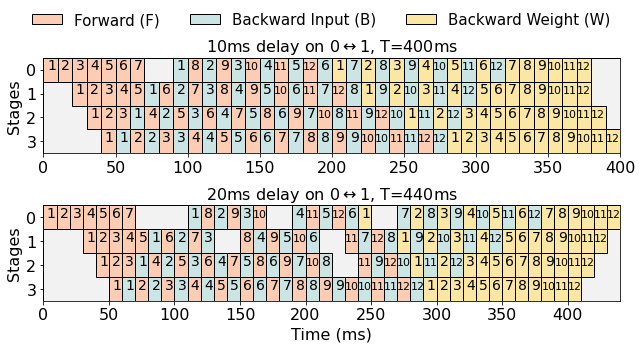

In [4]:
num_stages, num_batches = 4, 12
update_times([10]*num_stages, [10]*num_stages, [10]*num_stages, [1]*num_stages)
policy = OurPolicy(num_stages)
simulator = PipelineSimulator(num_stages, num_batches, policy, [], {}, True)
simulator.simulate()
simulator.export("./originalzb.txt")
plt.figure(figsize=(9, 5))
ax = plt.subplot(211)
simulator = PipelineSimulator(num_stages, num_batches, FixedPolicy(num_stages, './originalzb.txt'), [], {(0, 1): 10}, True)
simulator.simulate()
simulator.plot(ax)
plt.ylabel("Stages", fontdict={"fontsize": 16})
plt.title(f"10ms delay on 0$\leftrightarrow$1, T={simulator.get_iter_time():.0f}ms", fontdict={"fontsize": 16})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax  = plt.subplot(212)
simulator = PipelineSimulator(num_stages, num_batches, FixedPolicy(num_stages, './originalzb.txt'), [], {(0, 1): 20}, True)
simulator.simulate()
simulator.plot(ax)
plt.title(f"20ms delay on 0$\leftrightarrow$1, T={simulator.get_iter_time():.0f}ms", fontdict={"fontsize": 16})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Stages", fontdict={"fontsize": 16})
plt.bar(0, 0, label="Forward (F)", color=ForwardBatch(0).color, edgecolor='black')
plt.bar(0, 0, label="Backward Input (B)", color=BackwardInputBatch(0).color, edgecolor='black')
plt.bar(0, 0, label="Backward Weight (W)", color=BackwardWeightBatch(0).color, edgecolor='black')
plt.xlabel("Time (ms)", fontdict={"fontsize": 16})
legend = plt.figlegend(loc='upper center', bbox_to_anchor=(0.5, 0.98), fontsize=15, ncols=3, frameon=False)
plt.tight_layout(pad=1.0, rect=(0, 0, 1, 0.9)) 

plt.savefig("delayzb.pdf")